In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from matplotlib import pyplot as plt
from pretty_confusion_matrix import pp_matrix_from_data
import datetime


In [2]:
DATA_PATH = "MFCC_data.json"
# SAVE_MODEL_PATH = "model_mfcc.h5"
LEARNING_RATE = 0.001
EPOCHS = 40
BATCH_SIZE = 32

# his model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.
def load_dataset(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    
    return X, y


def get_data_splits(data_path, test_size=0.1, test_validation=0.1):
    
    # load the dataset
    X, y = load_dataset(data_path)
    
    # create train/ validation/ test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,
                                                                    test_size=test_validation) # 0.1 of 0.9 -> 0.09
    
    # convert inputs from 2d to 3d arrays
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape, learning_rate):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation="relu"))
#     model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(256, activation="relu"))
#     model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(64, activation="relu"))
    # model.add(keras.layers.Dropout(0.3))
    

    
    model.add(keras.layers.Dense(4, activation="softmax"))


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    # model.summary()
    
    return model
    

def main():
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = get_data_splits(DATA_PATH)
    
    # build model
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # (segments, coefficients <13>, 1)
    model = build_model(input_shape, LEARNING_RATE)
    
    # train the model
    log_dir = "mfcc_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = 'mfcctmp/checkpoint'

    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
    backup_callback = keras.callbacks.BackupAndRestore(backup_dir="mfcctmp/backup")
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath+"/{epoch:02d}-{val_accuracy:.2f}",
        monitor='val_accuracy',
        mode='max',
        save_freq='epoch',
        period=1,
        save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(X_validation, y_validation),
                        callbacks=[tensorboard_callback, model_checkpoint_callback, backup_callback])
    
    # evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")
    
#     model.save(SAVE_MODEL_PATH)

    #eval
    # 
    print("evaling .......................")
    model.evaluate(X_test,y_test) 
    
    preds = model.predict(X_test)
    preds = np.array([np.argmax(x) for x in preds])

    str_labels = ['down', 'left', 'right', 'up']

    pp_matrix_from_data(preds, y_test, cmap='Blues_r', columns=str_labels)
    return model, history 

Epoch 1/40
216/216 [==============================] - 3s 13ms/step - loss: 3.6974 - accuracy: 0.5049 - val_loss: 0.8618 - val_accuracy: 0.6406
Epoch 2/40
216/216 [==============================] - 2s 11ms/step - loss: 0.7655 - accuracy: 0.7188 - val_loss: 0.6470 - val_accuracy: 0.7630
Epoch 3/40
216/216 [==============================] - 2s 11ms/step - loss: 0.5812 - accuracy: 0.7866 - val_loss: 0.5459 - val_accuracy: 0.8060
Epoch 4/40
216/216 [==============================] - 2s 11ms/step - loss: 0.4682 - accuracy: 0.8316 - val_loss: 0.4827 - val_accuracy: 0.8490
Epoch 5/40
216/216 [==============================] - 1s 4ms/step - loss: 0.3445 - accuracy: 0.8767 - val_loss: 0.4491 - val_accuracy: 0.8385
Epoch 6/40
216/216 [==============================] - 2s 11ms/step - loss: 0.3570 - accuracy: 0.8734 - val_loss: 0.4091 - val_accuracy: 0.8672
Epoch 7/40
216/216 [==============================] - 2s 11ms/step - loss: 0.3098 - accuracy: 0.8857 - val_loss: 0.3485 - val_accuracy: 0.8763


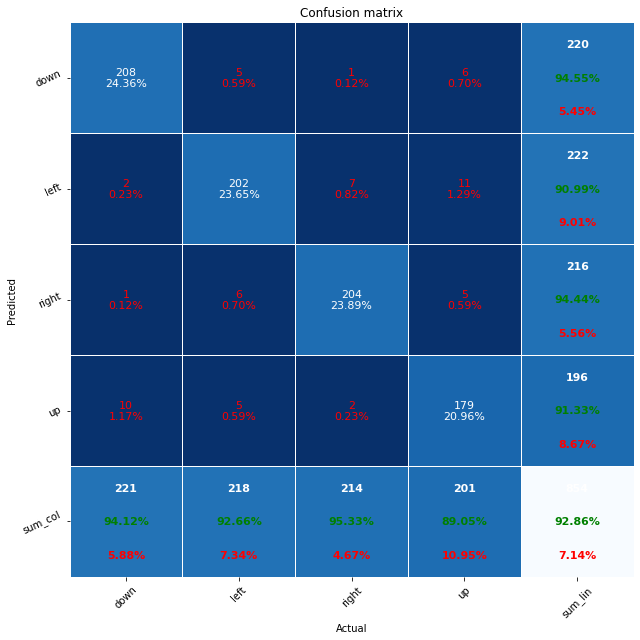

In [3]:
if __name__ == "__main__":
    model, history  = main()

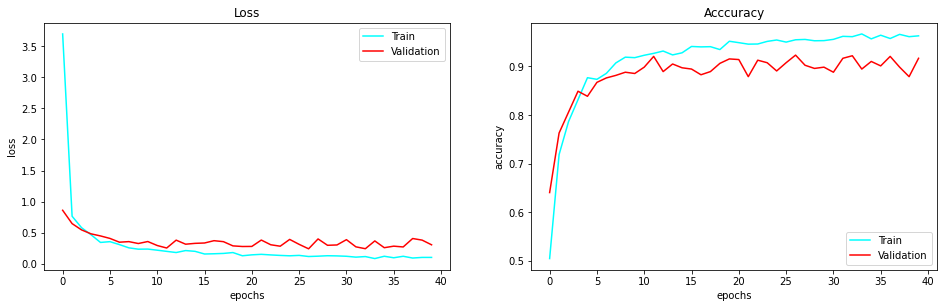

In [4]:
plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], color='cyan')
plt.plot(history.history['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='cyan')
plt.plot(history.history['val_accuracy'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplots_adjust(wspace=0.2)


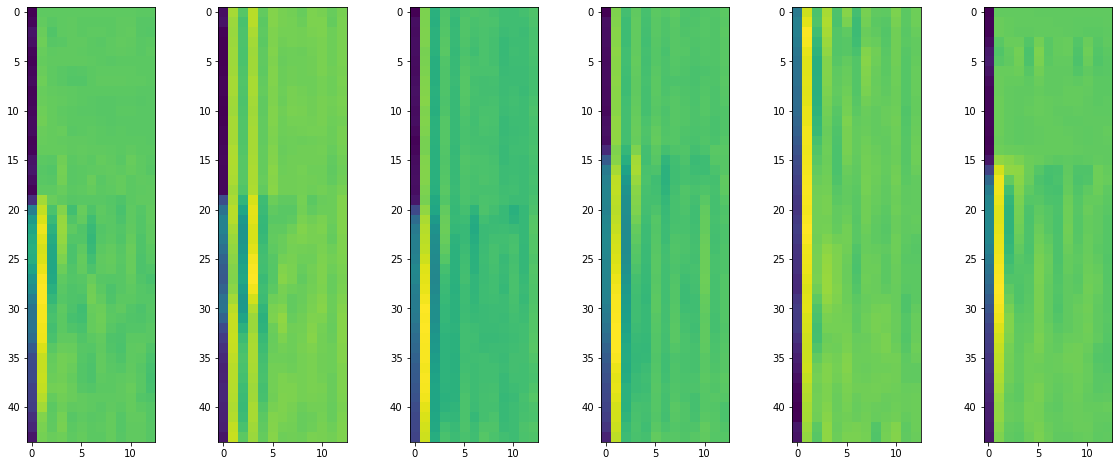

In [5]:
X, y = load_dataset(DATA_PATH)

plt.figure(figsize=(20,8))

for i in range(6):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(X[i])
    
plt.show()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 572)               0         
                                                                 
 dense (Dense)               (None, 128)               73344     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 4)                 2